# Module 1: Profit Curves


*  Data => https://www.kaggle.com/datasets/blastchar/telco-customer-churn
*  Code base => https://github.com/wandb/edu/blob/main/decision-opt-course/1_profit_curves.ipynb



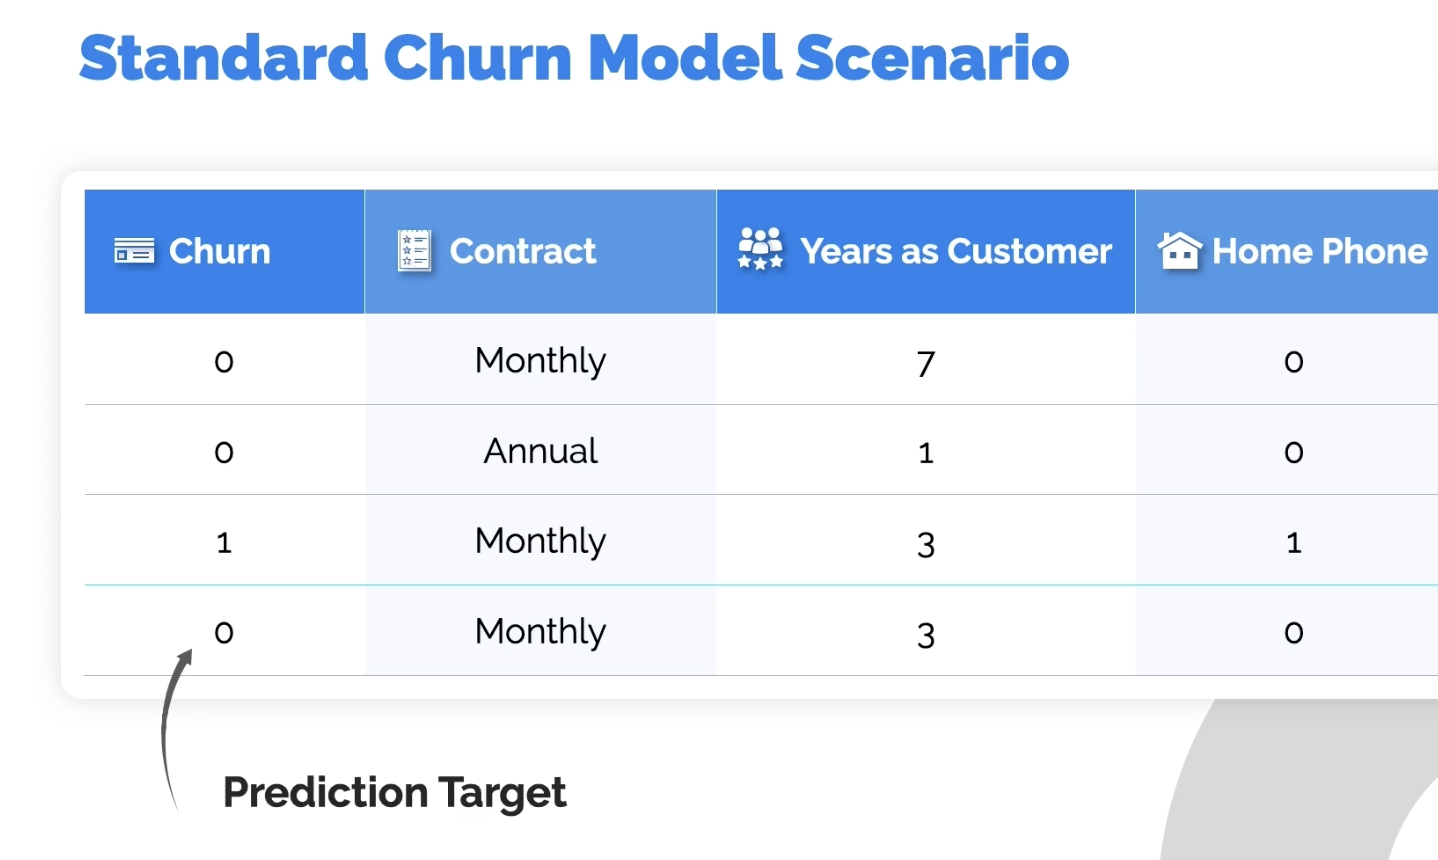

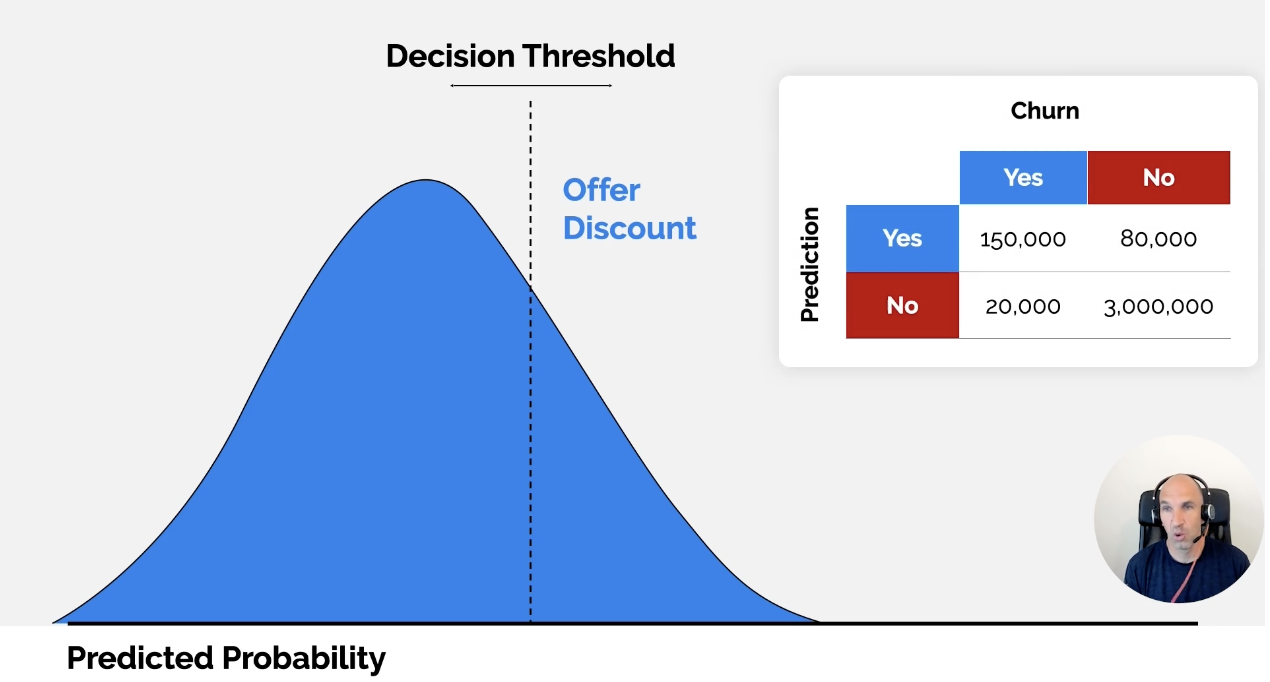

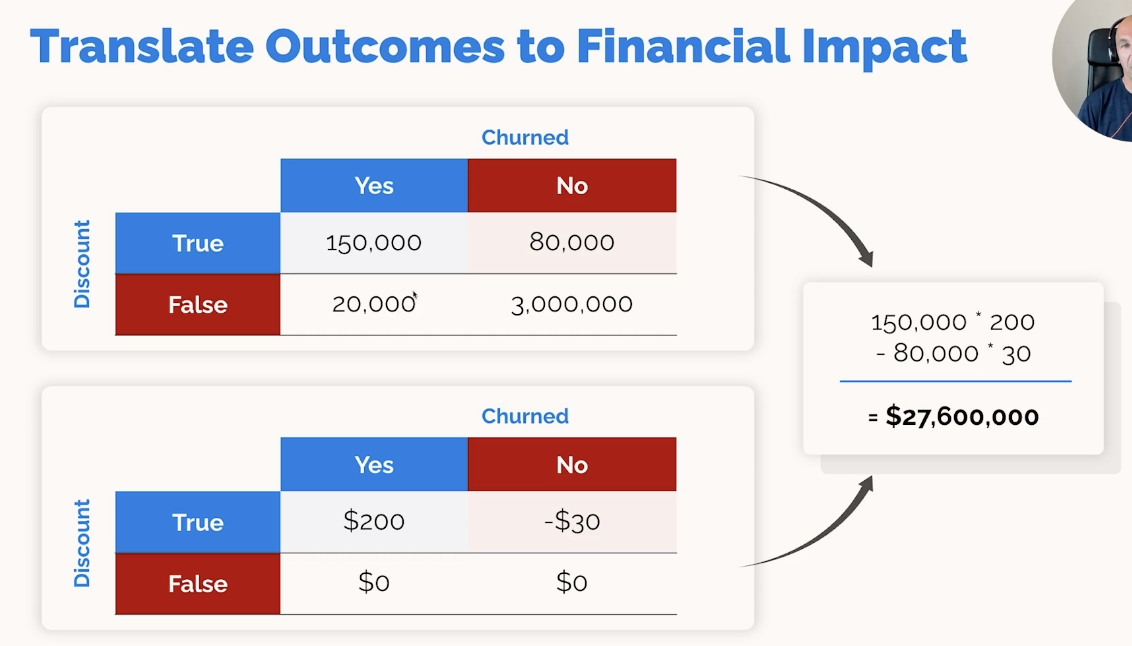

![image.png]()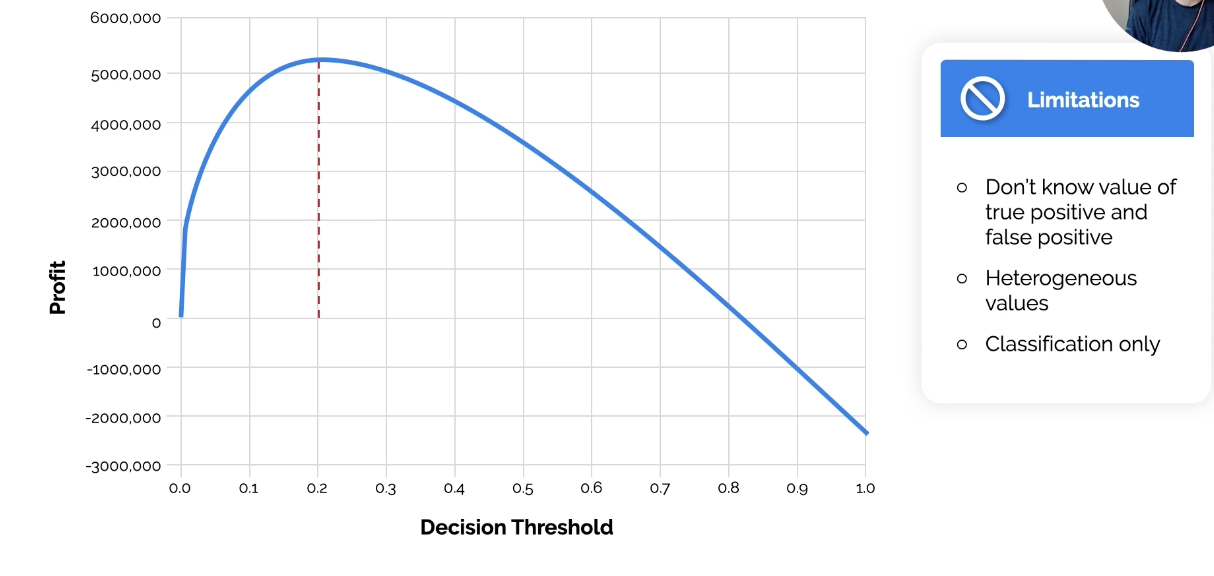

In [1]:
%pip install wandb xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
wandb.login()

NameError: name 'wandb' is not defined

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.compose import make_column_selector as selector
from wandb.xgboost import WandbCallback
from xgboost import XGBClassifier
from pathlib import Path
plt.style.use('fivethirtyeight')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Study/ML for Business Decision Optimization

/content/drive/MyDrive/Study/ML for Business Decision Optimization


In [7]:
data = pd.read_csv("resources/Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. Create  Weights & Biases project

In [ ]:
run1 = wandb.init(project="profit_curves")

wandb: Currently logged in as: jose-arango. Use `wandb login --relogin` to force relogin


### 2. Create pipeline to transform data

In [8]:
target = "Churn"

In [9]:
data[target] == "Yes"

0       False
1       False
2        True
3       False
4        True
        ...  
7038    False
7039    False
7040    False
7041     True
7042    False
Name: Churn, Length: 7043, dtype: bool

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target] == "Yes", test_size=0.2, random_state=0)

In [11]:
cols_to_use = [
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
]

In [12]:
#Create column transformer
preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))],
    remainder="passthrough",  # Leave numerical variables unchanged
)

In [13]:
"""Create pipeline
Preprocesso | model
"""
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier())])

### 3. Train model using pipeline

In [14]:
X_train[cols_to_use]

,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2920,72,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,85.10
2966,14,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,46.35
6099,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.70
5482,33,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,73.90
2012,47,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,98.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,15,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,103.45
3264,10,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,91.10
1653,58,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.75
2607,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.75


In [15]:
X_train[cols_to_use].dtypes

tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
dtype: object

In [16]:
# Filtre columns to use
pipeline.fit(X_train[cols_to_use], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x784d33efd5a0>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### 4. Compute metrics

In [17]:
"""
- Column 0: No Churn (probability)
- Column 1: Churn (probability)
"""
y_pred = pipeline.predict_proba(X_test[cols_to_use])[:,1]

In [18]:
y_pred

array([0.03667343, 0.05432237, 0.43688783, ..., 0.17900313, 0.08747198,
       0.741891  ], dtype=float32)

In [19]:
y_pred.shape

(1409,)

In [20]:
X_test.shape

(1409, 20)

In [21]:
roc_auc = roc_auc_score(y_test, y_pred) #Label and probabilities
log_loss_val = log_loss(y_test, y_pred)

In [22]:
print("ROC AUC:", roc_auc)

ROC AUC: 0.8070730484901641


In [23]:
print("LOG LOSS VAL:", log_loss_val)

LOG LOSS VAL: 0.49149944984693583


### Convert probability prediction to label (1,0)

In [24]:
threshold = 0.5  # Set your custom threshold here

In [26]:
y_pred_binary = np.where(y_pred >= threshold, 1, 0) # >0.5 => 1, otherwise 0

In [27]:
y_pred_binary

array([0, 0, 0, ..., 0, 0, 1])

In [28]:
cm = confusion_matrix(y_test, y_pred_binary)
# format is
# [[TN, FP],
#  [FN, TP]]

In [29]:
print("Confusion Matrix")
cm

Confusion Matrix


array([[902, 139],
       [184, 184]])

### 5. Profit curve

In [30]:
def profit_curve(y_true, y_pred, payoff_matrix, n_points=101):
    """Calculate profit curve for a binary classifier.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        payoff_matrix (array-like): Payoff matrix.
        n_points (int): Number of points to calculate.

    Returns:
        tuple: x and y values for the profit curve.
    """
    # Calculate profit for each threshold
    thresholds = np.linspace(0, 1, n_points)
    profits = []
    for threshold in thresholds:
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        cm = confusion_matrix(y_true, y_pred_binary)
        profit = (cm * payoff_matrix).sum()
        profits.append(profit)
    return thresholds, profits

### payoff_matrix

In [31]:
# Costs $80 to give discount to a customer who will not churn (Fase Positive) FP (BAD) 👎
# Worth $200 to give discount to a customer who will otherwise churn (True Positive) TP (GOOD) 👍
payoff_matrix = np.array([[0, -80], [0, 200]])

# format is
# [[TN, FP],
#  [FN, TP]]

In [32]:
print(payoff_matrix)

[[  0 -80]
 [  0 200]]


In [33]:
thresholds, profits = profit_curve(y_test, y_pred, payoff_matrix)
print(thresholds)
print(profits)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[-9680, 13720, 18280, 21400, 23320, 24800, 25000, 25280, 26480, 27280, 28160, 29000, 29320, 29680, 30480, 30800, 30640, 31000, 30040, 30680, 30280, 30040, 30440, 30280, 30080, 30080, 29800, 29560, 29120, 29160, 29360, 30000, 30200, 30560, 29600, 29400, 30000, 30400, 29800, 29680, 29200, 28920, 28760, 28520, 28520, 28720, 27240, 26640, 26320, 26280, 25680, 26080, 25400, 25880, 25640, 25480, 24880, 24600, 23560, 23160, 22680, 22360, 22200, 22000, 21960, 21040, 21000, 20360, 20000, 18

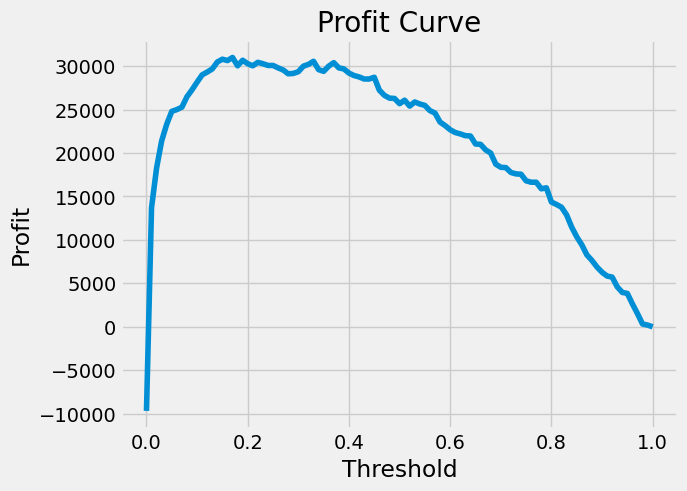

In [34]:
plt.plot(thresholds,profits)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title("Profit Curve")
plt.show()

#### Best threshold that maximizes profit

In [35]:
def find_best_threshold_and_profit(thresholds, profits):
    """Find the best threshold and profit.

    Args:
        thresholds (array-like): Threshold values.
        profits (array-like): Profit values.

    Returns:
        tuple: Best threshold and profit.
    """
    best_profit_value = max(profits)
    best_profit_index = profits.index(best_profit_value)
    best_threshold = thresholds[best_profit_index]
    return best_threshold, best_profit_value


In [36]:
best_threshold, best_profits = find_best_threshold_and_profit(thresholds, profits)

In [37]:
str(best_threshold),best_profits

('0.17', 31000)

In [38]:
def plot_profit_curve(thresholds,profits,best_threshold,best_profits, title="Profit Curve"):
  plt.plot(thresholds,profits)
  plt.axhline(y=best_profits, color='red', linestyle='--', label="Best profit(USD) = "+str(best_profits))
  plt.axvline(x=best_threshold, color='green', linestyle='--', label="Best threshold = "+str(best_threshold))
  plt.xlabel('Threshold')
  plt.ylabel('Profit')
  plt.title(title)
  plt.legend()
  plt.show()

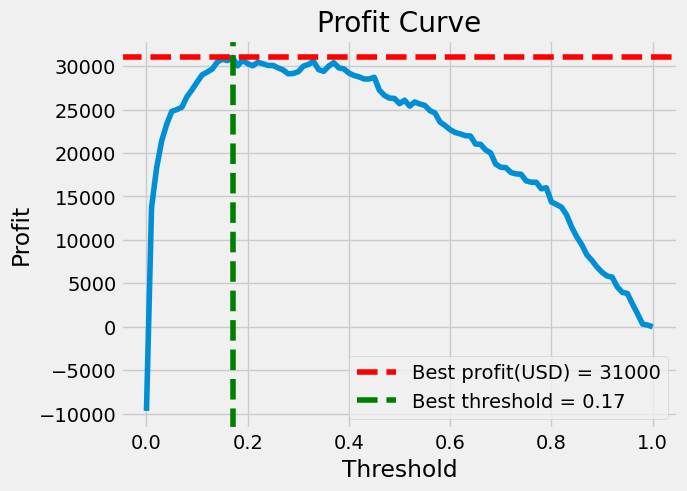

In [39]:
plot_profit_curve(thresholds,profits,best_threshold,best_profits)

In [40]:
print(f"Ideal threshold is {best_threshold:.2f} which yields profits of ${best_profits:.0f}")

Ideal threshold is 0.17 which yields profits of $31000


# Module 2: Having a broken data pipeline - Prioritizing Work

The decision to exclude the field that was lost or recover it carries a lot of work and potential monetary value behind it, so stay tuned to learn how to best navigate this situation.

In [ ]:
cols_to_use, len(cols_to_use)

(['tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges'],
 14)

In [ ]:
field_lost_in_broken_pipeline = "tenure"

#### Extract lost field

In [ ]:
# refit model and get new predictions without this field
new_cols_to_use = [col for col in cols_to_use if col != field_lost_in_broken_pipeline]

In [ ]:
new_cols_to_use, len(new_cols_to_use)

(['PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges'],
 13)

#### Train with lost field

In [ ]:
pipeline.fit(X_train[new_cols_to_use], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x785ed0a47430>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

#### Compute metrics

In [ ]:
new_y_pred = pipeline.predict_proba(X_test[new_cols_to_use])[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test, new_y_pred)
log_loss_val = log_loss(y_test, new_y_pred)

In [ ]:
print("ROC AUC:", roc_auc)
print("LOG LOSS VAL:", log_loss_val)

ROC AUC: 0.7828632063651172
LOG LOSS VAL: 0.5051601699564157


In [ ]:
new_thresholds, new_profits = profit_curve(y_test, new_y_pred, payoff_matrix)
new_best_thresh, new_best_profits = find_best_threshold_and_profit(new_thresholds, new_profits)
print(f"Ideal threshold is {new_best_thresh:.2f} which yields profits of ${new_best_profits:.0f}")

Ideal threshold is 0.26 which yields profits of $29640


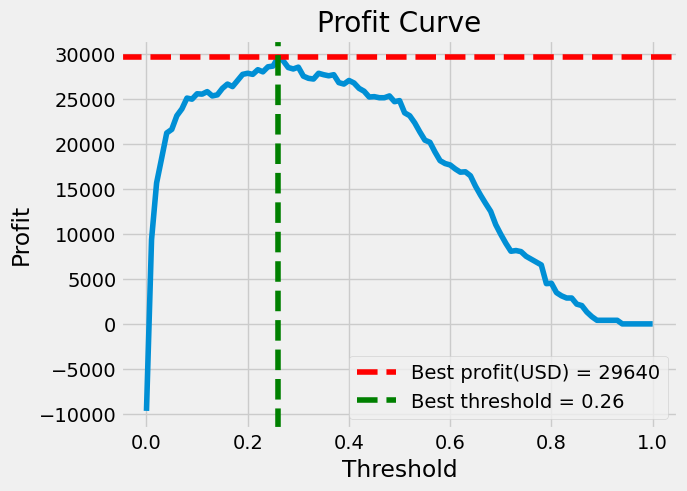

In [ ]:
plot_profit_curve(new_thresholds,new_profits,new_best_thresh,new_best_profits)

#### IMPORTANT

The field Contract It makes us lose 320 dollars (-320)

The most important field is tenure. It is an interesting exercise to see modify this code slightly and see how the results change when you remove tenure. We can lose 1360 Dollars

In [ ]:
print(f"Change in profit due to lost field: {new_best_profits - best_profits:.0f}")

Change in profit due to lost field: -1360


# Module 3: Model Improvements

Another important decision machine learning practitioners, management and anyone working with models face is 'Should I keep improving this model or move on to a new project?'

In [41]:
y_pred,y_test

(array([0.03667343, 0.05432237, 0.43688783, ..., 0.17900313, 0.08747198,
        0.741891  ], dtype=float32),
 2200    False
 4627    False
 3225    False
 2828    False
 3768    False
         ...  
 2631     True
 5333     True
 6972     True
 4598    False
 3065    False
 Name: Churn, Length: 1409, dtype: bool)

In [44]:
errors = y_pred - y_test
errors

2200    0.036673
4627    0.054322
3225    0.436888
2828    0.002047
3768    0.423205
          ...   
2631   -0.042262
5333   -0.395524
6972   -0.820997
4598    0.087472
3065    0.741891
Name: Churn, Length: 1409, dtype: float32

In [43]:
y_pred-errors

2200    0.0
4627    0.0
3225    0.0
2828    0.0
3768    0.0
       ... 
2631    1.0
5333    1.0
6972    1.0
4598    0.0
3065    0.0
Name: Churn, Length: 1409, dtype: float32

In [ ]:
y_test

2200    False
4627    False
3225    False
2828    False
3768    False
        ...  
2631     True
5333     True
6972     True
4598    False
3065    False
Name: Churn, Length: 1409, dtype: bool

In [ ]:
y_pred-errors*0.8

2200    0.007335
4627    0.010864
3225    0.087378
2828    0.000409
3768    0.084641
          ...   
2631    0.991548
5333    0.920895
6972    0.835801
4598    0.017494
3065    0.148378
Name: Churn, Length: 1409, dtype: float32

In [ ]:
y_pred

array([0.03667343, 0.05432237, 0.43688783, ..., 0.17900313, 0.08747198,
       0.741891  ], dtype=float32)

In [ ]:
print((0.036673*0.86)/100)

0.00031538779999999993


In [ ]:
0.036673-0.00031538779999999993

0.0363576122

In [ ]:
closeness_factor=0.14
errors*closeness_factor

2200    0.005134
4627    0.007605
3225    0.061164
2828    0.000287
3768    0.059249
          ...   
2631   -0.005917
5333   -0.055373
6972   -0.114940
4598    0.012246
3065    0.103865
Name: Churn, Length: 1409, dtype: float32

In [49]:
def make_synth_accurate_data(y_pred, y_true, closeness_factor=0.1):
    """Create synthetic data that is accurate.

    Args:
        y_pred (array-like): Predicted probabilities.
        y_true (array-like): True labels.
        closeness_factor (float): A measure of how much to increase the accuracy of the synthetic data.

    Returns:
        array: Synthetic data.
    """
    errors = y_pred - y_true
    synth_data = y_pred - errors * closeness_factor
    synth_data_AUC = roc_auc_score(y_true, synth_data)
    print(
        f"closeness_factor: {closeness_factor:.2f}.   AUC of synthetic data: {synth_data_AUC:.2f}"
    )
    return synth_data

In [50]:
for i in np.linspace(0, 0.2, 11):
    make_synth_accurate_data(y_pred, y_test, i)

closeness_factor: 0.00.   AUC of synthetic data: 0.81
closeness_factor: 0.02.   AUC of synthetic data: 0.83
closeness_factor: 0.04.   AUC of synthetic data: 0.84
closeness_factor: 0.06.   AUC of synthetic data: 0.85
closeness_factor: 0.08.   AUC of synthetic data: 0.86
closeness_factor: 0.10.   AUC of synthetic data: 0.87
closeness_factor: 0.12.   AUC of synthetic data: 0.88
closeness_factor: 0.14.   AUC of synthetic data: 0.89
closeness_factor: 0.16.   AUC of synthetic data: 0.90
closeness_factor: 0.18.   AUC of synthetic data: 0.91
closeness_factor: 0.20.   AUC of synthetic data: 0.92


A closeness factor of 0.14 creates synthetic data that's a proxy for how good we expect predictions to be after this modeling improvement (recall that we hypothesized the modeling improvement would yield an AUC of 0.9)

In [ ]:
synth_preds = make_synth_accurate_data(y_pred, y_test, 0.14)
print(
    f"""
Sanity check that means make sense:
{synth_preds.mean():.3f}
{y_pred.mean():.3f}
{y_test.mean():.3f}
"""
)

closeness_factor: 0.14.   AUC of synthetic data: 0.89

Sanity check that means make sense:
0.261
0.261
0.261



Now show profit curves we expect after this modeling improvement. We'll compare it to the profit curve from the best model built so far.

In [51]:
synth_preds = make_synth_accurate_data(y_pred, y_test, 0.15)
roc_auc = roc_auc_score(y_test, synth_preds)
log_loss_val = log_loss(y_test, synth_preds)

synth_pred_thresholds, synth_pred_profits = profit_curve(y_test, synth_preds, payoff_matrix)
synth_best_thresh, synth_best_profits = find_best_threshold_and_profit(synth_pred_thresholds, synth_pred_profits)
print(f"Ideal threshold is {synth_best_thresh:.2f} which yields profits of ${synth_best_profits:.0f}")

closeness_factor: 0.15.   AUC of synthetic data: 0.90
Ideal threshold is 0.15 which yields profits of $46000


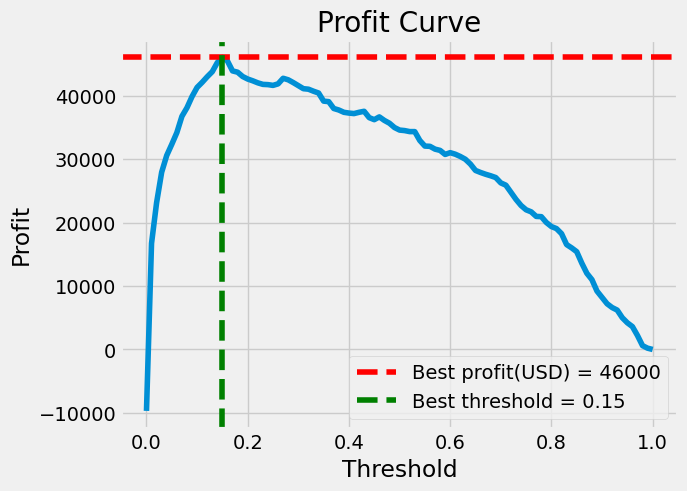

In [52]:
plot_profit_curve(synth_pred_thresholds,synth_pred_profits,synth_best_thresh,synth_best_profits)

# Module 4: Beyond Simple-Number Decision Thresholds



As you can see, there are different customers groups, someone's spend more money monthly than others.

Text(0, 0.5, 'Frequency')

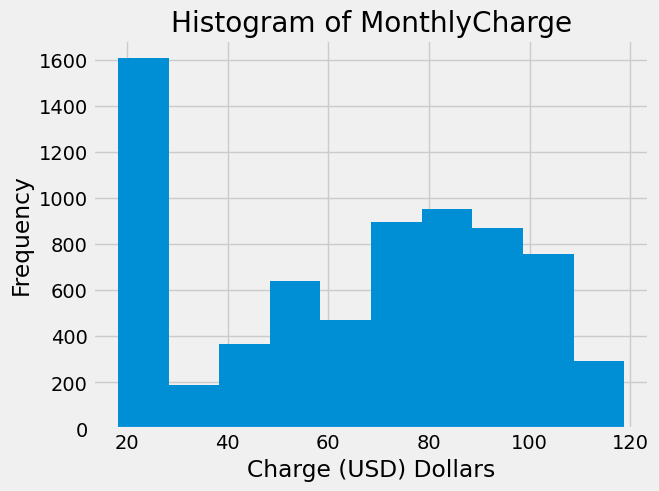

In [ ]:
data.MonthlyCharges.hist()
plt.title("Histogram of MonthlyCharge")
plt.xlabel("Charge (USD) Dollars")
plt.ylabel("Frequency")

In [ ]:
# Previously assumed this was 200 for all customers.
# Mean MonthlyCharge is 68
X_test["value_of_promoting_to_churning_customer"] = data.MonthlyCharges * 3
# Previously assumed this was -80 for all customers.
X_test["cost_of_promoting_to_non_churning_customer"] = -80

In [ ]:
def group_specific_profit_curve(X_test, y_test, y_pred, low_thresh, high_thresh,title):
    #filter group
    in_group = (X_test.MonthlyCharges > low_thresh) & (
        X_test.MonthlyCharges <= high_thresh
    )
    y_test_in_group = y_test[in_group]
    y_pred_in_group = y_pred[in_group]

    mean_monthly_charge = X_test.MonthlyCharges[in_group].mean()

    payoff_matrix = np.array([[0, -80], [0, 3 * mean_monthly_charge]])

    thresholds, profits = profit_curve(y_test_in_group, y_pred_in_group, payoff_matrix)
    best_thresh, best_profits = find_best_threshold_and_profit(thresholds, profits)

    plot_profit_curve(thresholds,profits,best_thresh,best_profits,title)
    return best_thresh, best_profits

Divide customers into three groups and assign different thresholds for each



Threshold for customers paying less than $20/month


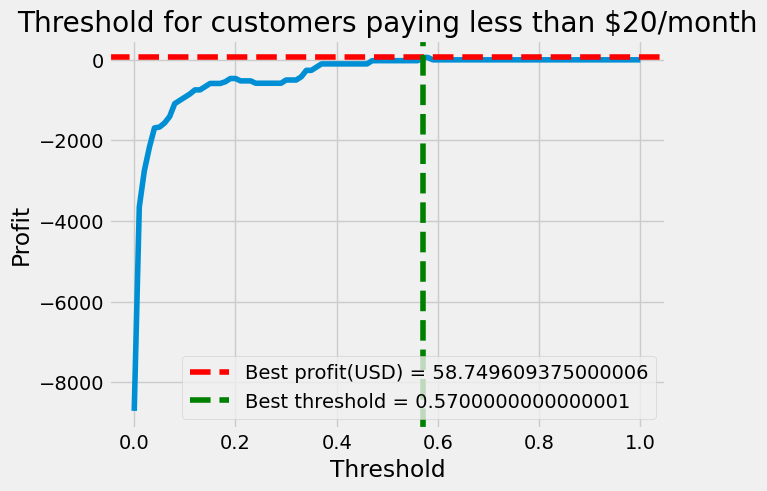

Threshold for customers paying between $20 and $60/month


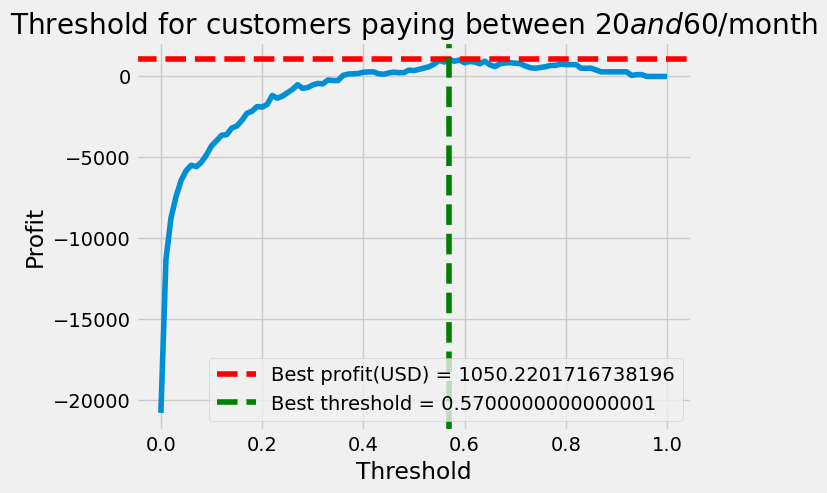

Threshold for customers paying between $60 and $100/month


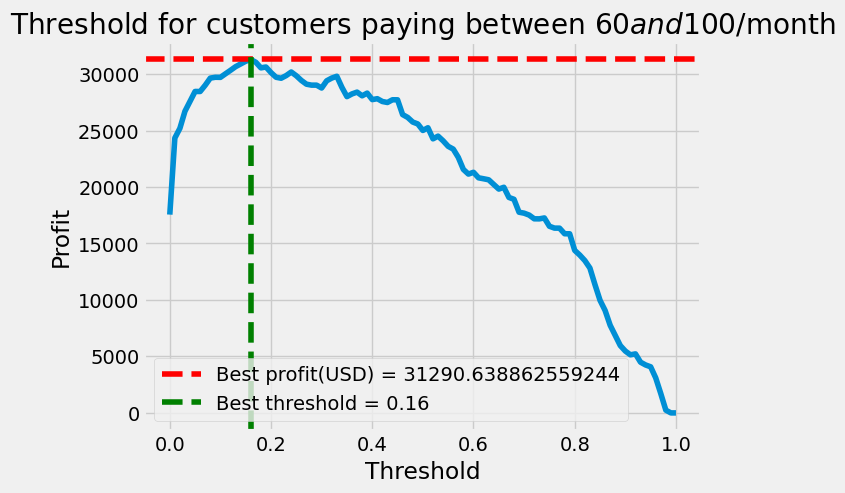

Threshold for customers paying more than $100/month


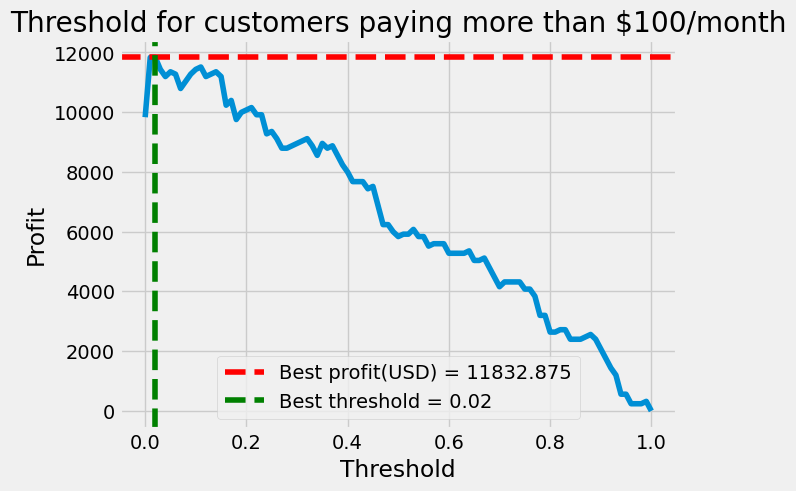

In [ ]:
# Find ideal threshold for customers paying less than $20/month
title = "Threshold for customers paying less than $20/month"
print(title)
thresh_low, profits_low = group_specific_profit_curve(X_test, y_test, y_pred, 0, 20,title)


# Find ideal threshold for customers paying between $20 and $60/month
title="Threshold for customers paying between $20 and $60/month"
print(title)
thresh_medium, profits_medium = group_specific_profit_curve(
    X_test, y_test, y_pred, 20, 60,title
)

# Find ideal threshold for customers paying between $60 and $100/month
title="Threshold for customers paying between $60 and $100/month"
print(title)
thresh_high, profits_high = group_specific_profit_curve(X_test, y_test, y_pred, 60, 100,title)


# Find ideal threshold for customers paying more than $100/month
title = "Threshold for customers paying more than $100/month"
print(title)
thresh_very_high, profits_very_high = group_specific_profit_curve(
    X_test, y_test, y_pred, 100, 200, title
)


In [ ]:
flexible_threshold_profit =profits_low + profits_medium + profits_high + profits_very_high

In [ ]:
flexible_threshold_profit

44232.483643608066

In [ ]:
print(
    f"""
With flexible thresholds, the profit is {(flexible_threshold_profit):.0f}.
Previous profit was {best_profits}"""
)


With flexible thresholds, the profit is 44232.
Previous profit was 31000


**13.232 USD - More dollars with a simple decision**

In [ ]:
print(f"{flexible_threshold_profit - best_profits:0.0f}")

13232
